# Телеком: исследование оттока клиентов

**Цель: выяснить связь величин ежемесячных платежей с отказом от обслуживания.**
<br>Пока создаётся модель прогнозирования оттока клиентов, отдел маркетинга «Ниединогоразрыва.ком» приступает к проработке способов их удержания. Предстоит собрать нужную для этого информацию.
<br>**План действий:**
- Исследовательский анализ каждого датафрейма
- Сравнение распределения величин ежемесячных платежей всех клиентов и тех, кто ушёл
- Расчёт статистик, построение гистограмм
- Объединение датафреймов
- Анализ единого датафрейма
- Построение графиков, отображающих долю пользователей телефонной связи и
долю интернет-пользователей для всех клиентов и тех, кто ушёл

**Описание данных:**

- `contract.csv` — информация о договоре
  - `customerID` - идентификатор пользователя
  - `BeginDate` - дата заключения договора
  - `EndDate` - дата расторжения договора
  - `Type` - тип заключённого договора
  - `PaperlessBilling` - обмен документами без бумажного носителя
  - `PaymentMethod` - способ оплаты и вариант подтверждения платежа
  - `MonthlyCharges` - ежемесячный платёж
  - `TotalCharges` - всего внесено дунежных средств
- `phone.csv` - информация об услугах телефонии
  - `customerID` - идентификатор пользователя
  - `MultipleLines` - подключение телефонного аппарата к нескольким линиям одновременно
- `internet.csv` — информация об интернет-услугах
    - `customerID` - идентификатор пользлователя
    - `InternetService` - тип подключения к сети интернет
    - `OnlineSecurity` - подключение услуги блокировки небезопасных сайтов
    - `OnlineBackup` - подключение облачного хранилища файлов для резервного копирования данных
    - `DeviceProtection` - подключение антивируса
    - `TechSupport` - подключение выделенной линии технической поддержки
    - `StreamingTV` - подключение стримингового телевидения
    - `StreamingMovies` - подключение каталога фильмов

## Инструменты

Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

## Подготовка и анализ данных

Открытие датасетов

In [ ]:
try:
  contract = pd.read_csv('/home/contract.csv')
  phone = pd.read_csv('/home/phone.csv')
  personal = pd.read_csv('/home/personal.csv')
  internet = pd.read_csv('/home/internet.csv')
except:
  contract = pd.read_csv('C:/Users/nvmor/Documents/workshop/projects/final_project/final_provider/contract.csv')
  phone = pd.read_csv('C:/Users/nvmor/Documents/workshop/projects/final_project/final_provider/phone.csv')
  internet = pd.read_csv('C:/Users/nvmor/Documents/workshop/projects/final_project/final_provider/internet.csv')

**Открытие файла `contract` и ознакомление со структурой данных**

In [ ]:
display(contract.sample(5))
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4332,4194-FJARJ,2015-08-01,No,Two year,No,Bank transfer (automatic),60.00,3273.95
3052,5151-HQRDG,2017-01-01,No,Month-to-month,Yes,Mailed check,55.05,2030.75
3401,4299-OPXEJ,2015-06-01,No,Two year,Yes,Bank transfer (automatic),19.55,1080.55
759,5684-FJVYR,2014-02-01,No,Two year,Yes,Bank transfer (automatic),90.35,6563.4
6818,2710-WYVXG,2019-11-01,No,Two year,No,Mailed check,71.10,213.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Для категоризации целевого признака создам функцию `outflow_category`. На вход принимает значения столбца `EndDate`, возвращает 1 при наличии даты расторжения договора, либо 0, если договор действует.

In [ ]:
def outflow_category(row):
    end_date = row['EndDate']
    
    try:
        if end_date == 'No':
            return 0
        return 1
    except:
        display('Введено некорректное значение')
        
contract['outflow_category'] = contract.apply(outflow_category, axis=1)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   outflow_category  7043 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


In [ ]:
contract.outflow_category.value_counts()

0    5174
1    1869
Name: outflow_category, dtype: int64

Построение "Ящиков с усами" для визуализации распределения размера ежемесячного платежа

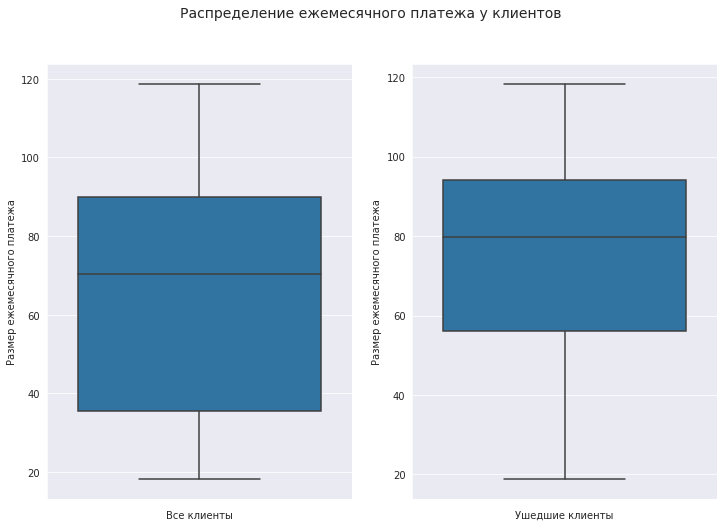

In [ ]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Распределение ежемесячного платежа у клиентов', fontsize=14)

sns.boxplot(ax=axes[0], data=contract, y='MonthlyCharges')
axes[0].set_xlabel('Все клиенты', fontsize=10)
axes[0].set_ylabel('Размер ежемесячного платежа', fontsize=10)

sns.boxplot(ax=axes[1], data=contract.query('outflow_category == 1'), y='MonthlyCharges')
axes[1].set_xlabel('Ушедшие клиенты', fontsize=10)
axes[1].set_ylabel('Размер ежемесячного платежа', fontsize=10)

plt.show()

In [ ]:
display('Описательные статистики ежемесячных платежей всех клиентов', '', 
        contract['MonthlyCharges'].describe())

'Описательные статистики ежемесячных платежей всех клиентов'

''

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [ ]:
display('Описательные статистики ежемесячных платежей ушедших клиентов', '', 
        contract.query('outflow_category == 1')['MonthlyCharges'].describe())

'Описательные статистики ежемесячных платежей ушедших клиентов'

''

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

Построение Гистограмм для визуализации распределения размера ежемесячного платежа

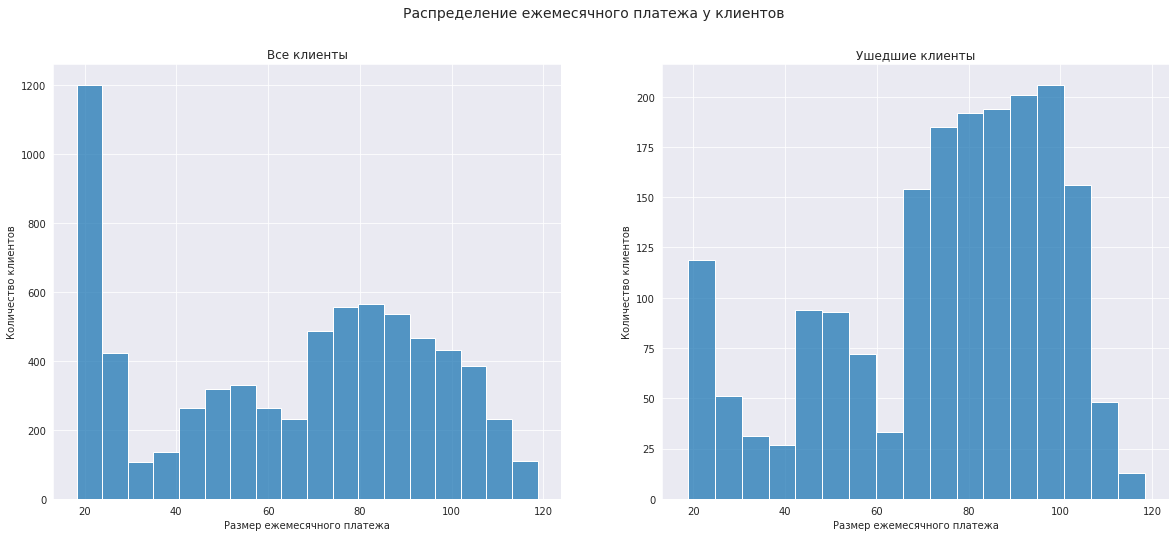

In [ ]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
fig.suptitle('Распределение ежемесячного платежа у клиентов', fontsize=14)

sns.histplot(ax=axes[0], data=contract, x='MonthlyCharges')
axes[0].set_title('Все клиенты')
axes[0].set_xlabel('Размер ежемесячного платежа', fontsize=10)
axes[0].set_ylabel('Количество клиентов', fontsize=10)

sns.histplot(ax=axes[1], data=contract.query('outflow_category == 1'), x='MonthlyCharges')
axes[1].set_title('Ушедшие клиенты')
axes[1].set_xlabel('Размер ежемесячного платежа', fontsize=10)
axes[1].set_ylabel('Количество клиентов', fontsize=10)

plt.show()

**Выводы:**
- в среднем ежемесячные платежи ушедших клиентов выше, чем у клиентов в целом
- медианное значение платежей у них также имеет более высокое значение
- минимальное значение платежей практически одинаковое, также, как и максимальное

**Открытие файла `phone` и ознакомление со структурой данных**

In [ ]:
display(phone.sample(5))
phone.info()

,customerID,MultipleLines
4329,8224-KDLKN,Yes
5073,7228-OMTPN,No
2314,9825-YCXWZ,No
4979,7856-GANIL,Yes
22,6467-CHFZW,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Добавление нового столбца для идентификации

In [ ]:
phone.insert(1, 'phone', 1)

**Открытие файла `internet` и ознакомление со структурой данных**

In [ ]:
display(internet.sample(5))
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1580,8086-OVPWV,Fiber optic,No,No,No,No,No,Yes
2449,8336-TAVKX,DSL,Yes,Yes,Yes,Yes,No,Yes
1854,8739-XNIKG,Fiber optic,No,No,No,No,Yes,No
2093,8348-HFYIV,DSL,No,No,Yes,No,Yes,Yes
4960,3214-IYUUQ,Fiber optic,Yes,Yes,No,Yes,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Добавление нового столбца для идентификации

In [ ]:
internet.insert(1, 'internet', 1)

## Объединение датафреймов

In [ ]:
all_data = contract.merge(phone, how='left', left_on='customerID', right_on='customerID')
all_data = all_data.merge(internet, how='left', left_on='customerID', right_on='customerID')

Отсечение ненужных признаков, заполнение пропусков

In [ ]:
filtered_df = all_data[['customerID', 'outflow_category', 'phone', 'internet']]
filtered_df = filtered_df.fillna(0)

Построение графиков

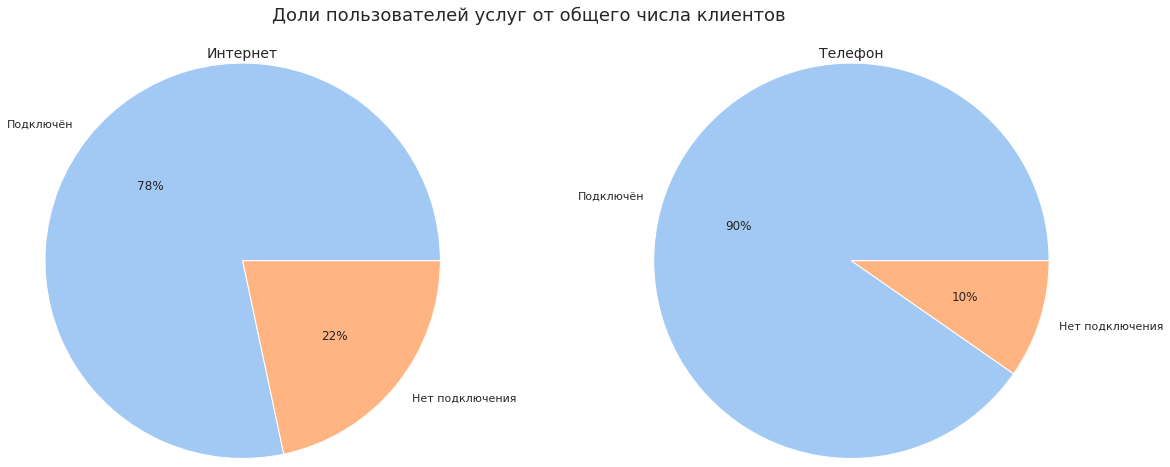

In [ ]:
sns.set()
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
fig.suptitle('Доли пользователей услуг от общего числа клиентов', y=1.15, fontsize=18)

ax1 = plt.subplot(221)
ax1.pie(filtered_df.internet.value_counts(), labels = ['Подключён', 'Нет подключения'], 
        radius=2.5, colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
ax1.set_title('Интернет', y=1.5, fontsize=14)

ax2 = plt.subplot(222)
ax2.pie(filtered_df.phone.value_counts(), labels = ['Подключён', 'Нет подключения'], 
        radius=2.5, colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
ax2.set_title('Телефон', y=1.5, fontsize=14)

plt.show()

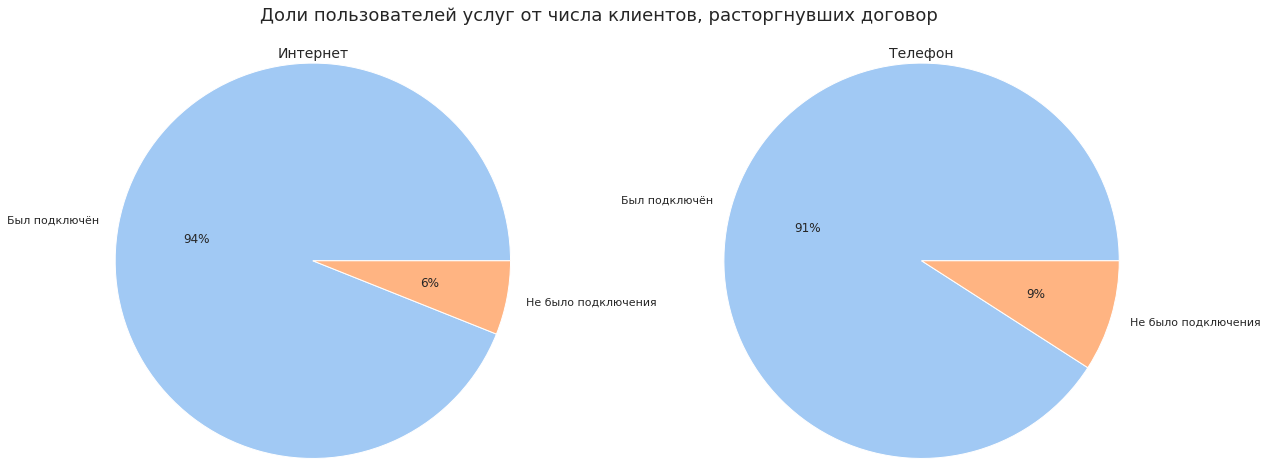

In [ ]:
sns.set()
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
fig.suptitle('Доли пользователей услуг от числа клиентов, расторгнувших договор', 
             y=1.15, fontsize=18)

ax1 = plt.subplot(221)
ax1.pie(filtered_df.query('outflow_category == 1').internet.value_counts(), 
        labels = ['Был подключён', 'Не было подключения'], radius=2.5, 
        colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
ax1.set_title('Интернет', y=1.5, fontsize=14)

ax2 = plt.subplot(222)
ax2.pie(filtered_df.query('outflow_category == 1').phone.value_counts(), 
        labels = ['Был подключён', 'Не было подключения'], radius=2.5, 
        colors = sns.color_palette('pastel')[0:5], autopct='%.0f%%')
ax2.set_title('Телефон', y=1.5, fontsize=14)

plt.show()

Выводы:
- из числа действующих клиентов у 22% нет подключения к интернету и у 10% нет подключения к телефонии
- из числа ушедших клиентов без подключения к телефонии было примерно такое же количество - 9%, без интернет-услуг было всего лишь 6%

## Общее заключение

- в среднем ежемесячные платежи ушедших клиентов выше, чем у клиентов в целом
- медианное значение платежей у них также имеет более высокое значение
- минимальное значение платежей практически одинаковое, также, как и максимальное
- из числа действующих клиентов у 22% нет подключения к интернету и у 10% нет подключения к телефонии
- из числа ушедших клиентов без подключения к телефонии было примерно такое же количество - 9%, без интернет-услуг было всего лишь 6%